In [20]:
from tsai.all import *
import logging
import matplotlib.pyplot as plt
import zarr
# import tensorflow
# from tensorflow.python.client import device_lib

In [21]:
# def get_available_devices():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos]

# print(get_available_devices())

In [22]:
computer_setup()

os             : Linux-5.4.0-131-generic-x86_64-with-glibc2.29
python         : 3.8.10
tsai           : 0.3.1
fastai         : 2.7.9
fastcore       : 1.5.24
torch          : 1.11.0+cu102
device         : 1 gpu (['NVIDIA GeForce GTX 980 Ti'])
cpu cores      : 12
RAM            : 15.56 GB
GPU memory     : [5.94] GB


In [23]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [24]:
def list_from_file(filename):
    with open(filename, "rb") as fp:
        return pickle.load(fp)

In [25]:
file_data = '23_11'
today_date = '26_12'
model_name = "LSTM_FCN"
#Problem to solve
problem = "Multiclass"

file_for_train_data = 'train_data_' + file_data
file_for_train_data_x = file_for_train_data + '_x'
file_for_train_data_y = file_for_train_data + '_y'

folder_to_save = 'export_' + today_date + '_' + model_name + '_' + problem
file_to_save = './' + problem + '_' + today_date + '_' + model_name + '.pkl'

In [26]:
logger.info(f"Get train data from files: {file_for_train_data_x}, {file_for_train_data_y}")
X = list_from_file(file_for_train_data_x)
Y = list_from_file(file_for_train_data_y)

INFO:__main__:Get train data from files: train_data_23_11_x, train_data_23_11_y


In [27]:
path = Path('data')
if not os.path.exists(path): os.makedirs(path)

In [28]:
logger.info("Create numpy array with X and Y")
X_largest = np.array(X)
y_large = np.array(Y)

# logger.info("Sample X for every 100 samples")
X_large = X_largest[:, :, ::10]
X_large.shape

INFO:__main__:Create numpy array with X and Y


(420, 4, 4001)

In [29]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='w', shape=X_large.shape, dtype=X_large.dtype, chunks=(1, -1, -1))
# chunks=(1, -1, -1) == (1, None, None)
X_large_zarr[:] = X_large

In [30]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='r')
y_large_zarr = zarr.open(path/'y_large.zarr', mode='w', shape=y_large.shape, dtype=y_large.dtype, chunks=False) # y data is small and don't need to be chunked
y_large_zarr[:] = y_large

INFO:__main__:Split data to train and valid


stratify set to False as the least populated class in o has only 1 member, which is too few.


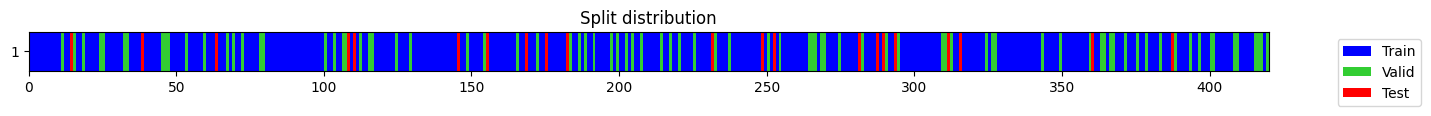

((#315) [355,357,240,216,334,3,22,96,117,407...],
 (#84) [67,266,416,154,25,112,217,419,199,186...],
 (#21) [175,145,63,387,231,293,287,289,315,248...])

In [31]:
valid_size              = 0.2
test_size               = 0.05
train_only              = False  # set to True for debugging (valid = train)
stratify                = True
balance                 = False
shuffle                 = True
predefined_splits       = None
show_plot               = True 


check_splits = True
random_state = 23
logger.info("Split data to train and valid")
#Set show plot to True if you want to see split, but this stops main thread
splits = get_splits(X_large_zarr, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)
splits

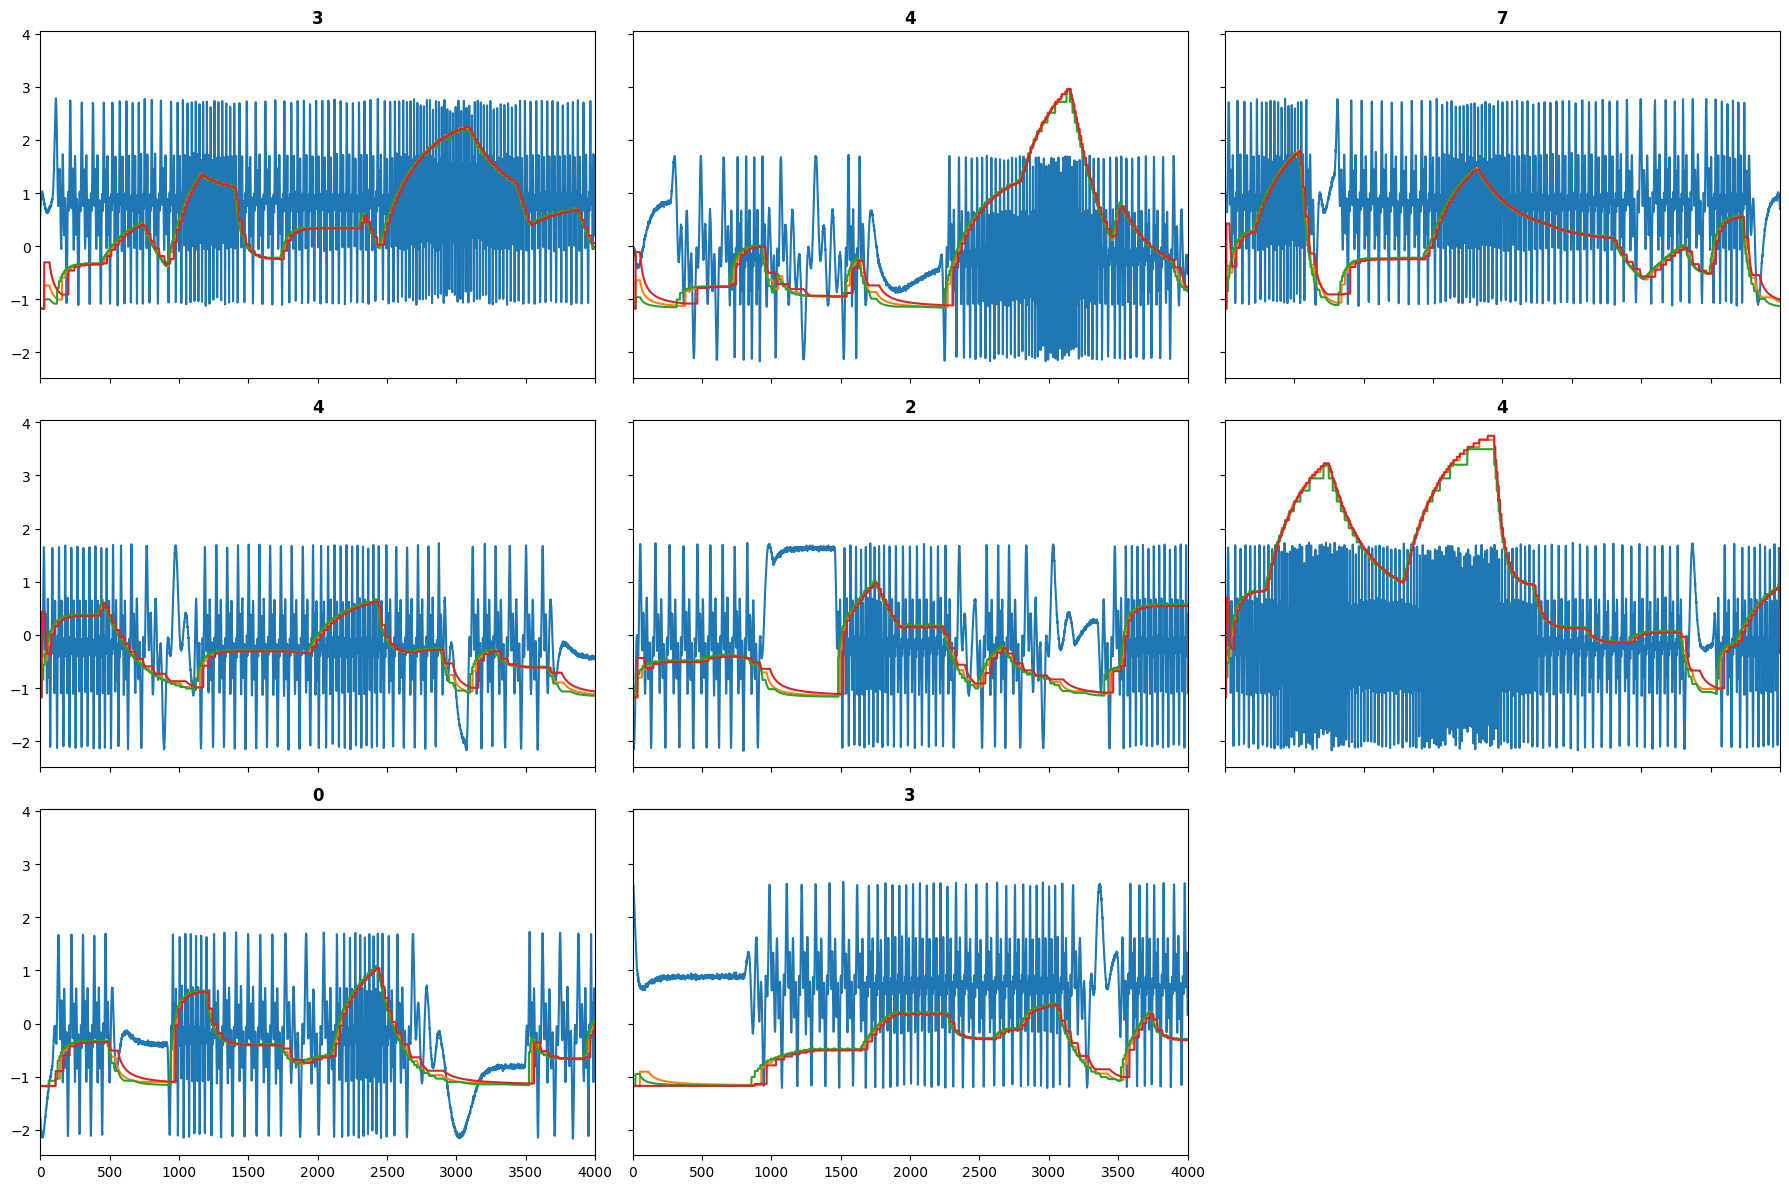

In [32]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X_large_zarr, y_large_zarr, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=8, num_workers=12) 
# num_workers = 1 *cpus
dls.show_batch(sharey=True)

In [33]:
if model_name == "LSTM":
    model = LSTM(dls.vars, dls.c, hidden_size=100, bidirectional=True)
elif model_name == "LSTM_FCN":
    model = LSTM_FCN(dls.vars, dls.c, seq_len=X_large.shape[-1], hidden_size=1000, bidirectional=True)
elif model_name == "FCNPlus":
    model = FCNPlus(dls.vars, dls.c)
else:
    raise Exception("Error: Provided bad model name")
print(dls.c)

8


In [34]:
logger.info("Initialize learner")
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
logger.info("Save learner as stage0")
learn.save('stage0')

INFO:__main__:Initialize learner
INFO:__main__:Save learner as stage0


Path('models/stage0.pth')

INFO:__main__:Initialize learner


epoch,train_loss,valid_loss,accuracy,time
0,2.101486,1.991252,0.226190,00:04
1,1.958096,2.002471,0.238095,00:03
2,1.838418,1.980568,0.297619,00:03
3,1.722339,1.994624,0.297619,00:04
4,1.609063,1.993656,0.273810,00:03
5,1.511155,1.986690,0.261905,00:03
6,1.422426,1.991146,0.250000,00:03
7,1.338218,1.986812,0.285714,00:03
8,1.279115,1.991003,0.250000,00:03
9,1.193139,1.985767,0.297619,00:03


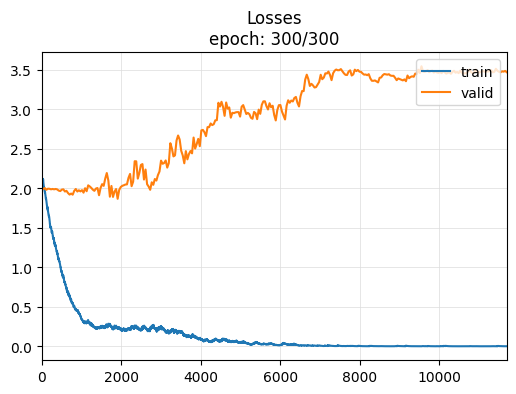

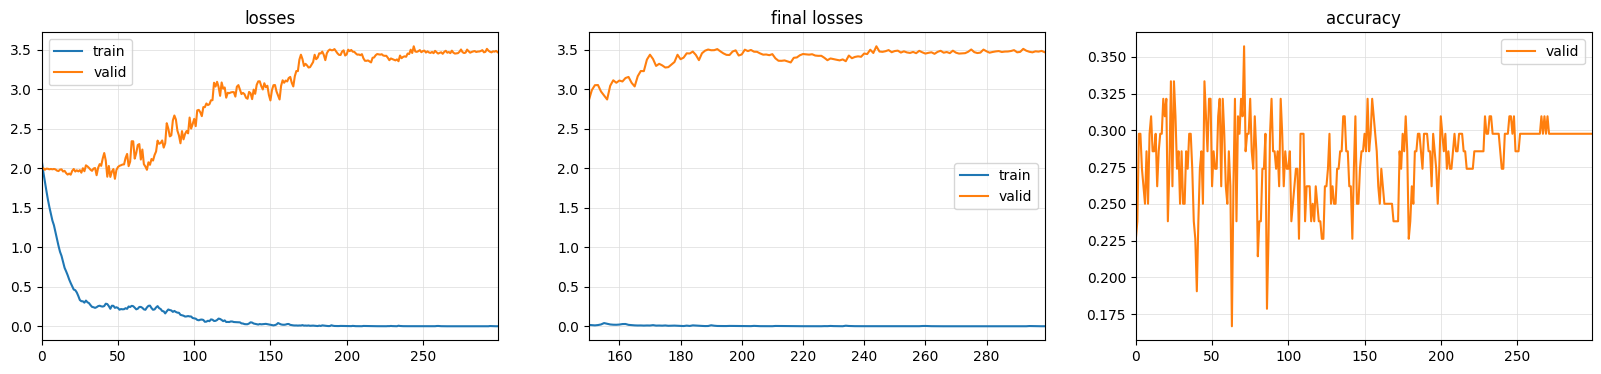

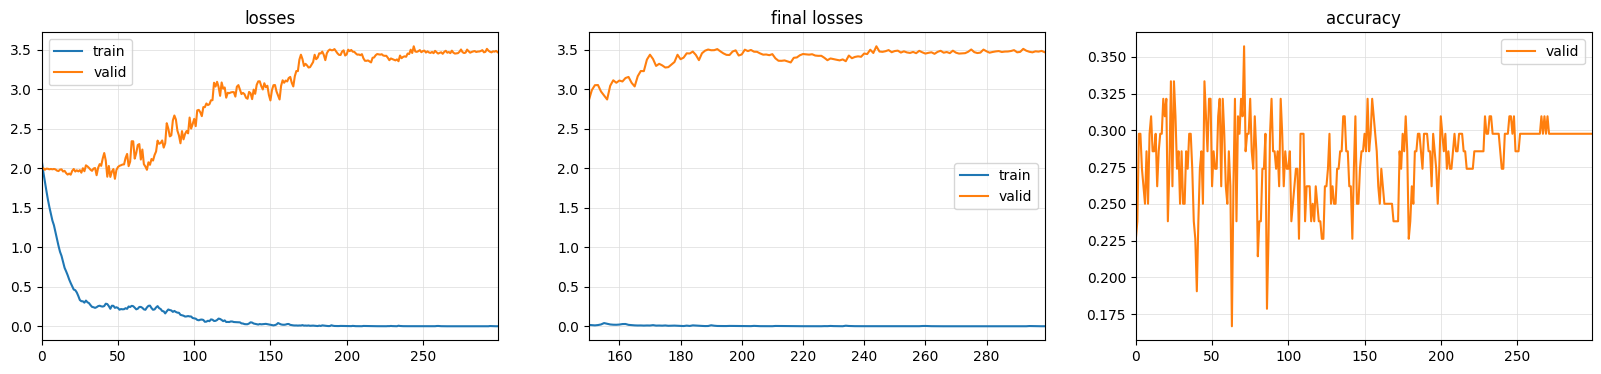

In [35]:
logger.info("Initialize learner")
learn.fit_one_cycle(300, lr_max=1e-3)
learn.save('stage1')
learn.recorder.plot_metrics()

In [36]:
PATH = Path(file_to_save)
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

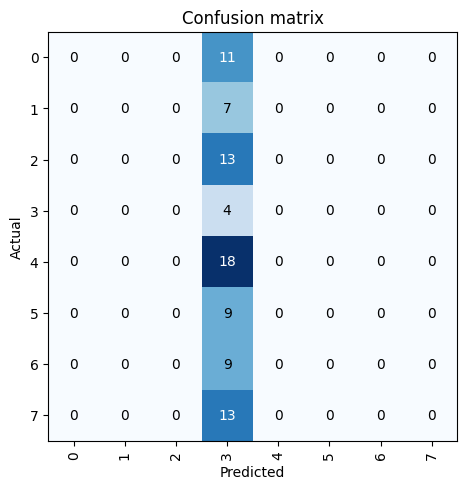

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

learn.save_all(path=folder_to_save, dls_fname='dls', model_fname='model', learner_fname='learner')
#sF - Dryft czujnika
#sV - Shaft Wear, Zużycie wału
#sT - Tooth fault, Uszkodzenie zęba przekładni

#faultCode = sF + 2*sV + 4*sT
# 0 - brak uszkodzeń
# 1 - Dryft czujnika
# 2 - Zużycie wału
# 3 - Dryft czujnika + Zużycie wału
# 4 - Uszkodzenie zęba przekładni
# 5 - Uszkodzenie zęba przekładni + Dryft czujnika
# 6 - Uszkodzenie zęba przekładni + Zużycie wału
# 7 - Uszkodzenie zęba przekładni + Zużycie wału + Dryft czujnika

(array([56., 42., 56., 42., 64., 48., 64., 48.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

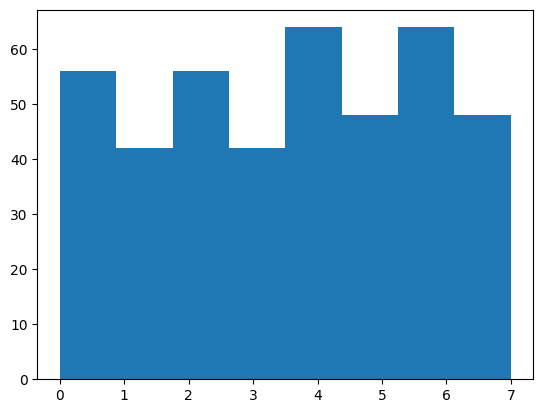

In [38]:
plt.hist(Y, 8)

In [45]:
splits[0]

(#315) [355,357,240,216,334,3,22,96,117,407...]